# This is module to perform fits for covariant data. It uses the Choleksy decomposition and lmfit.minimize modules.

## Steps:

- Read file
- Block data
- Calculate covariance matrix
- Calculate mean of correlators

- Get data in xdata,ydata,yerrs,cov,crss
- Choose fit
- Perform fit
- Print fit
- Plot fit

# Incomplete


## What this code does:
- It has a set of fitting functions. Easy to add new functions. Just follow template.
- It has a numpy array fits_info that stores all the information about the different types of fits.
- f_choose_fit has 2 modes. In one mode, it reads through all functions to set N and fits_info. In the other mode, it picks a certain fit function.


## Variables:
- func -> fit function chosen.
- fits_info has : fitnumber, name of fit, parameter list, number of parameters, functional form of fit
- dict1 is a dictionary storing parameter names and trial values input. Trial values are in string form and are converted to np.float64.
- xdata,ydata,yerr
- result -> stores the fit result.
- pars -> dictionary of parameters automatically obtained from lmfit module. !!Very important!! Needed for fixing parameter values. Internal to the f_fit function
- fit_ans -> stores the fit parameters.  Used for concise printing of result.
- fit_pars -> dictionary storing best-fit parameter values. Used for concise printing of result.

## Steps:

- Read f_choose_fit and store info
- Read input vars and choose fit.
- Read data and perform fit.
- print fit

In [2]:
import numpy as np
import numpy.linalg as linalg
import os,sys
import matplotlib.pyplot as plt
%matplotlib notebook
from lmfit import Model, Parameters, minimize, fit_report



import pandas as pd

In [3]:
# import imp
# foo = imp.load_source('f_sample_mean_err', '/Users/vpa/Desktop/Spyder/mean/mean_corr_functions.ipynb')
# foo.f_block()

In [4]:
# Functions to compute covariant matrix,and correlators from a multi-dimensional file.


def f_block(a, blk_size=1):
    '''
    Blocks the data given an array and block size and returns the blocked array.
    (Data is averaged inside the block).
    Discards last few numbers if block size is not a perfect divisor of total size.
    '''
    sz=a.shape[0]
    assert sz>0, 'input list is empty'
    num_blks=int(sz/blk_size) # Number of blocks 
    #Discarding last few numbers if block size is not a perfect divisor of total size.
    len_new=blk_size*num_blks
    a2=a[:len_new]
    sz=a2.shape[0]
    return np.mean(a2.reshape(num_blks,blk_size),axis=1)


def f_blk_all(f1,blk):
    '''
    Blocks all columns of numpy array.
    '''
    f2=np.zeros((f1.shape[0]/blk,f1.shape[1]),dtype=np.float64)

    for i,column in enumerate(f1.T): 
        f2[:,i]=f_block(column,blk)
    
    return f2

def f_covar(a,b):
    '''
    Computes the covariance for two numpy arrays 'a' and 'b'. Returns a number.
    '''
    return np.mean((a-np.mean(a))*(b-np.mean(b)))/len(a)

def f_calc_covar_mat(ff):
    '''
    Computes the covariance matrix for a series of variables. 
    Reads an MxN matrix and returns a covariance matrix of order NxN. 
    '''
    sz=ff.shape[1]
    cov_mat=np.zeros((sz,sz),dtype=np.float64)
    for i in range(sz):
        for j in range(sz):
            cov_mat[i,j]=f_covar(ff[:,i],ff[:,j])
    return cov_mat


In [5]:

def f_get_covar_data(lwlim,uplim,cov,crrs):
    '''
    Function to get data for covar fit.
    '''
    cinv=np.linalg.inv(cov)
    cinv=cinv[lwlim:uplim,lwlim:uplim]
    
    try:
        B=linalg.cholesky(cinv) # Cholesky matrix used in the fit method.
    except Exception as e:
        print e,"Cholesky decomposition didn't work"
        raise SystemError
    errs=np.sqrt(np.diag(cov))
    
    return np.arange(lwlim,uplim),crrs[lwlim:uplim],errs[lwlim:uplim],B


def f_choose_covar_fit(ftno):    
    '''
    Function to choose fit for covar fit.
    
    '''
    if ftno==1: # defining exponential fall with two powers
        par_names=['a1','m1','a2','m2']

        def f_func(pars,x):
            '''
            C(x)= a1 e^(-m1*x)+a2 e^(-m2*x)
            '''
            parvals=pars.valuesdict()            
            a1,m1,a2,m2=(parvals[key] for key in parvals)
            
            return a1*np.exp(-m1*x)+a2*np.exp(-m2*x)
            
        def f_residual(pars,x,ydata,cholesky):
            '''
            C(x)= a1 e^(-m1*x)+a2 e^(-m2*x)
            '''
            parvals=pars.valuesdict()
            
            a1,m1,a2,m2=(parvals[key] for key in parvals)
            fy=a1*np.exp(-m1*x)+a2*np.exp(-m2*x)
            dif=(fy-ydata)            
            
# #             This was the earlier code for checking the matrix products
#             modified_chi=np.dot(dif,np.dot(cinv,dif))
#             aa1,aa2=modified_chi,np.dot(np.dot(dif,B),np.dot(B.T,dif))
#             if not np.allclose(aa1,aa2):
#                 print "Error, Cholesky calc is not matching with actual calc",aa1,aa2
            
            return np.dot(dif,cholesky)
    elif ftno==2: # defining cosh fit with periodicity.
        par_names=['a1','m1','Nx']

        def f_func(pars,x):
            '''
            C(x)= a1 e^(-m1*x)+a1 e^(-m1*(Nx-x))
            '''
            # Equivalent to : 2 a_1 e^{-Nx m1/2} cosh ((Nx /2 - x)*m1)
            parvals=pars.valuesdict()            
            a1,m1,Nx=(parvals[key] for key in parvals)
            
            return a1*(np.exp(-m1*x)+np.exp(-m1*(Nx-x)))
            
        def f_residual(pars,x,ydata,cholesky):
            '''
            C(x)= a1 e^(-m1*x)+ a1 e^(-m2*(Nx-x))
            '''
            parvals=pars.valuesdict()
            a1,m1,Nx=(parvals[key] for key in parvals)
            fy=a1*(np.exp(-m1*x)+np.exp(-m1*(Nx-x)))
            dif=(fy-ydata)
            
# #             This was the earlier code for checking the matrix products
#             modified_chi=np.dot(dif,np.dot(cinv,dif))
#             aa1,aa2=modified_chi,np.dot(np.dot(dif,B),np.dot(B.T,dif))
#             if not np.allclose(aa1,aa2):
#                 print "Error, Cholesky calc is not matching with actual calc",aa1,aa2
            
            return np.dot(dif,cholesky)
    
    else:
        print "Invalid fit number"
        raise SystemExit
        
    print "Defined func",f_func.__doc__.strip('\n') # Prints the functional form of fit function.

    return f_residual,f_func,par_names


def f_do_fit_covar(f_residual,dict1,xdata,ydata,yerr,B):
    '''
    Performs the covar fits using the function 'func' and the lmfit module
    '''

    fx_list=[] # this stores the names of the parameters that are fixed
    for key in dict1:
        if dict1[key][0]=='f': # If string starts with f, that parameter will be fixed
            dict1[key]=np.float64(dict1[key][1:]) # Drop the first 'f' and store the rest as a float
            fx_list.append(key)
        else :
            dict1[key]=np.float64(dict1[key]) # Convert string to float

#     Creating a parameters() object            
    pars=Parameters()
    for key in dict1:
        pars.add(key,dict1[key])

    if fx_list: # checking if the list is empty
        for vv in fx_list: pars[vv].vary=False # Fix those parameters       

#     ot=minimize(f_residual, fit_params, args=(xdata,),kws={'ydata':ydata,'cholesky':B},method='powell')
#     result=minimize(f_residual, ot.params, args=(xdata,),kws={'ydata':ydata,'cholesky':B},method='leastsq') 
    result=minimize(f_residual, pars, args=(xdata,),kws={'ydata':ydata,'cholesky':B},method='leastsq')   
    summ=(fit_report(result))
    
    return result


def f_fit_covar_plot(result,func,xdata,ydata):
    '''
    Function to plot the results of covar fit.
    '''
    plt.plot(xdata,ydata,marker='*',linestyle='None',color='b')
    xx=np.linspace(min(xdata),max(xdata))
    plt.plot(xx,func(result.params,xx),color='r')
    plt.yscale('log')
    plt.xlabel('Euclidean time')
    plt.show()



In [6]:


def f_covar_fit(f1,ft_no,param,lwlim,uplim,blk=1):
    '''
    Function that uses all other modules to perform an entire covariance fit.
    '''
    
    assert f1.shape[1] > uplim-lwlim,"array length %d, is smaller than time range (%d) "%(f1.shape[1],(uplim-lwlim))
    f2=f_blk_all(f1,blk) 
    # Stores data after blocking
    cov=f_calc_covar_mat(f2)
    # Stores covariance matrix
    crrs=np.mean(f2,axis=0)
    # Stores averages
    
    xdata,ydata,yerr,B=f_get_covar_data(lwlim,uplim,cov,crrs)
    
    print xdata,ydata,yerr
    
    f_residual,f_func,par_names=f_choose_covar_fit(ft_no)

    assert len(par_names)==len(param),"Incorrect number of parameters"
    dict1={key:np.str(value) for (key,value) in zip(par_names,param)}

    result=f_do_fit_covar(f_residual,dict1,xdata,ydata,yerr,B)
    print fit_report(result)

    # Store fit results in a numpy array for further processing.
    fit_pars=result.params.valuesdict()# dictionary of best fit parameters
    fit_ans=np.zeros((len(fit_pars),3)).astype(str)
    for count,key in enumerate(fit_pars):# Store parameter name, value and error
        fit_ans[count]=np.array([key,result.params[key].value,result.params[key].stderr]).astype(str) 
    best_fit= np.float64(fit_ans[:,1]) # The fit values will be used in the plot function.

    # Print fit answer in a concise form
    for row in fit_ans:
        print '   '.join(str(n) for n in row)
    print 'Chi-sqr\t\t',result.redchi
    
    plt.figure()
    f_fit_covar_plot(result,f_func,xdata,ydata)
    return cov

### Simple covar fit

## Fit 1: Pion data from SU(4) project

In [7]:
# Read input file and store in data structures.
# Read file into dataframe. Input file from SU(4) project.
data_dir='test_data_files/'
fname=data_dir+'pointpion_12_24_74_163856'
df_pointpion=pd.read_csv(fname,sep='\t').reset_index().drop('index',1)
# df_pointpion
df1=df_pointpion[:]
df1;

# number of rows= num of configurations
# number of columns = number of correlators. Extracted from first entry of dataframe.
n_row=df1.shape[0]
n_col=np.array(df1['corr_data_re'][0].strip('[').strip(']').split(',')).shape[0]

corr_data=np.zeros(shape=(n_row,n_col))
for count,i in enumerate(df1['corr_data_re'].values):
    j=np.array(i.strip('[').strip(']').split(',')).astype(np.float64)
    corr_data[count]=j


In [8]:
# if __name__=="__main__":
ft_no=1
blk=1
lwlim,uplim=4,10
param=('1000','0.9','0','0')
# f1=np.loadtxt(file_name)
f1=corr_data
new_covr=f_covar_fit(f1,ft_no,param,lwlim,uplim,blk)

[4 5 6 7 8 9] [ 1591.44247059   657.92482353   271.72231765   111.75786216    45.7684151
    18.79675118] [ 26.90718594  12.64399806   5.99102088   2.75585118   1.23677211
   0.55424306]
Defined func             C(x)= a1 e^(-m1*x)+a2 e^(-m2*x)
            
[[Fit Statistics]]
    # function evals   = 75
    # data points      = 6
    # variables        = 4
    chi-square         = 3.778
    reduced chi-square = 1.889
    Akaike info crit   = 5.225
    Bayesian info crit = 4.392
[[Variables]]
    a1:   55285.5223 +/- 0        (0.00%) (init= 1000)
    a2:   0.88750920 +/- 0        (0.00%) (init= 0)
    m1:   301.687699 +/- 0        (0.00%) (init= 0.9)
    m2:   32.9937079 +/- 0        (0.00%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
a1   55285.522317   0
a2   0.887509201552   0
m1   301.687699136   0
m2   32.993707968   0
Chi-sqr		1.8891596034


<IPython.core.display.Javascript object>

## Notes on fitting:
- lmfit useful to do simple fits where you can fix parameters.
- gv.lsqfit is useful when the fit function doesn't have to be changed.

---------------------------------------------------------------------------------
---------------------------------------------------------------------------------
## Second fit 

[ 8  9 10 11 12 13 14 15 16 17 18 19] [  1.30425309e-05   6.66867943e-06   3.42237603e-06   1.75228909e-06
   8.70576292e-07   4.72686710e-07   2.47118984e-07   1.13446492e-07
   5.16991124e-08   2.80756308e-08   1.64311454e-08   9.23715560e-09] [  3.78453111e-07   2.78895399e-07   2.01420142e-07   1.35018764e-07
   8.04087578e-08   5.06016716e-08   3.40733350e-08   2.30091673e-08
   9.47468340e-09   6.09219406e-09   4.15971422e-09   2.30514243e-09]
Defined func             C(x)= a1 e^(-m1*x)+a2 e^(-m2*x)
            
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 12
    # variables        = 3
    chi-square         = 13231.561
    reduced chi-square = 1470.173
    Akaike info crit   = 90.065
    Bayesian info crit = 91.520
[[Variables]]
    a1:   0.00818244 +/- nan      (nan%) (init= 0.003)
    a2:   4.5035e-06 +/- nan      (nan%) (init= 0)
    m1:  -0.00818171 +/- nan      (nan%) (init= 0.6)
    m2:   0 (fixed)
[[Correlations]] (unreported correlations are < 

<IPython.core.display.Javascript object>


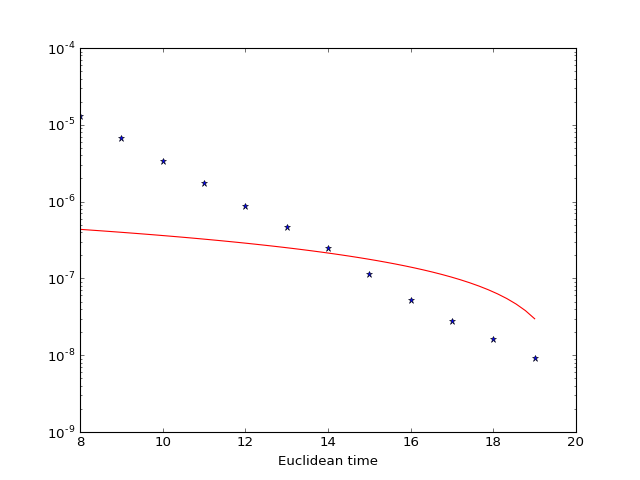

array([[  1.83873624e-10,   8.50727035e-11,   4.50913038e-11,
          2.55807165e-11,   1.41323084e-11,   8.26777982e-12,
          4.81617153e-12,   2.94139835e-12,   1.80065603e-12,
          1.06766047e-12,   6.47292413e-13,   3.79896562e-13,
          1.91608278e-13,   1.06765418e-13,   5.10512913e-14,
          1.75545001e-14,   8.85305142e-15,   5.30250030e-15,
          3.68670699e-15,   2.73090173e-15],
       [  8.50727035e-11,   5.22386036e-11,   2.91146867e-11,
          1.69895313e-11,   9.64177418e-12,   5.67684059e-12,
          3.27754945e-12,   1.97309382e-12,   1.14239183e-12,
          6.72065000e-13,   4.02189643e-13,   2.39818185e-13,
          1.18375074e-13,   7.01896356e-14,   2.98284523e-14,
          1.06091832e-14,   5.98449333e-15,   2.64870298e-15,
          2.16624136e-15,   1.51907315e-15],
       [  4.50913038e-11,   2.91146867e-11,   1.80733259e-11,
          1.09034072e-11,   6.36957394e-12,   3.82119382e-12,
          2.24290161e-12,   1.34181816e-12

In [10]:
f1=np.loadtxt('test_data_files/covar_fit_test_data.txt')
# if __name__=="__main__":
ft_no=1
blk=50
lwlim,uplim=8,20
param=('0.003','0.6','0','f0')
# f1=np.loadtxt(file_name)
# f1=corr_data
f_covar_fit(f1,ft_no,param,lwlim,uplim,blk)

[ 8  9 10 11 12 13 14 15 16 17 18 19] [  1.30425309e-05   6.66867943e-06   3.42237603e-06   1.75228909e-06
   8.70576292e-07   4.72686710e-07   2.47118984e-07   1.13446492e-07
   5.16991124e-08   2.80756308e-08   1.64311454e-08   9.23715560e-09] [  3.78453111e-07   2.78895399e-07   2.01420142e-07   1.35018764e-07
   8.04087578e-08   5.06016716e-08   3.40733350e-08   2.30091673e-08
   9.47468340e-09   6.09219406e-09   4.15971422e-09   2.30514243e-09]
Defined func             C(x)= a1 e^(-m1*x)+a2 e^(-m2*x)
            
[[Fit Statistics]]
    # function evals   = 361
    # data points      = 12
    # variables        = 4
    chi-square         = 6.872
    reduced chi-square = 0.859
    Akaike info crit   = 1.310
    Bayesian info crit = 3.250
[[Variables]]
    a1:   0.00300531 +/- 0.000306 (10.19%) (init= 0.003)
    a2:   0.68057990 +/- 0.013107 (1.93%) (init= 0)
    m1:   3.3855e-12 +/- 7.32e-11 (2161.36%) (init= 0.5)
    m2:  -0.36238208 +/- 1.122362 (309.72%) (init= 0)
[[Correlations]

<IPython.core.display.Javascript object>


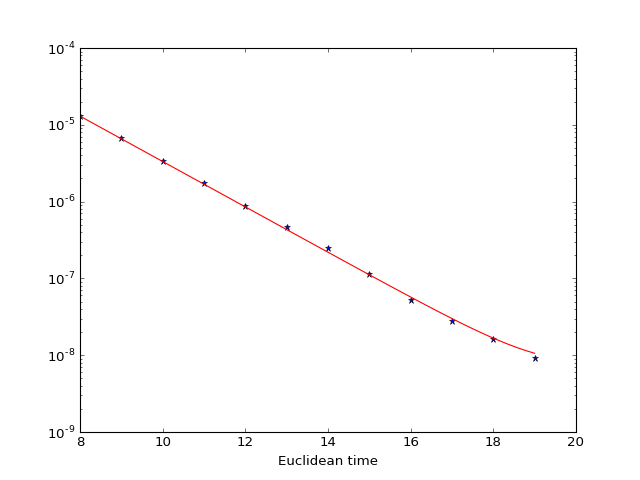

In [11]:
if __name__=="__main__":
    ft_no=1
    fld_name='test_data_files/'
    file_name=fld_name+'covar_fit_test_data.txt'
    blk=50
    lwlim,uplim=8,20
    param=('0.003','0.5','0','0')
    f1=np.loadtxt(file_name)
    f_covar_fit(f1,ft_no,param,lwlim,uplim,blk)


### Notes: 
- Fit works after using two powers or constant + power.
- But fit values are not sensible.



### To do :
- Read about covariance matrix.
- Check lmfit logic. covariance and Cholesky decomposition.
- Have already checked that covariance computation is correct by comparing with gvar.

